# STACKING ANALYSIS

### sped up stacking analysis using numba.jit decorator with nopython=true

In [1]:
import numpy as np
import pandas as pd
import os
import multiprocessing as mul
from multiprocessing import Process
import matplotlib.pyplot as plt
#import seaborn as sns
import itertools as itrt
from scipy.optimize import minimize
from scipy.optimize import curve_fit
from IPython.display import clear_output
from itertools import repeat
from functools import partial
from scipy.stats import chi2
from scipy.stats import norm
from scipy.stats import gaussian_kde
import scipy.stats as sct
from astropy.coordinates import SkyCoord as scr
from astropy import units as u
from time import sleep
from numba import jit, njit, prange
from tqdm import tqdm

In [2]:
####
#### IMPORTING AND SPLITTING ICDATA $$$


path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/events"
t_eff_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/uptime"
irf_path = "/media/darkwake/VIB2/Project-IceCube/icecube_10year_ps/irfs"
filenames = ["IC40_exp.csv", "IC59_exp.csv","IC79_exp.csv", "IC86_I_exp.csv", "IC86_II_exp.csv",
"IC86_III_exp.csv", "IC86_IV_exp.csv", "IC86_V_exp.csv", "IC86_VI_exp.csv", "IC86_VII_exp.csv"]
file = filenames[0]
f = open(os.path.join(path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
content = []
for file in filenames:
    f = open(os.path.join(path, file), 'r')
    lines = f.readlines()
    #print(len(lines) - 1)
    for line in lines[1:]:
        content.append(line.split())
    f.close()
icdata = pd.DataFrame(content, columns=column, dtype=float)#.convert_dtypes(infer_objects=True,convert_integer=True,convert_floating=True)
icdata['log10(E/GeV)'] = [float(i) for i in icdata['log10(E/GeV)']]
icdata['MJD[days]'] = [float(i) for i in icdata['MJD[days]']]

print("read icdata")
f.close()



#Importing UPtime data
file = filenames[0]
f = open(os.path.join(t_eff_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
uptdata = []
for file in filenames:
    content = []
    f = open(os.path.join(t_eff_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column)
    temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    uptdata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()


#Importing Aeff data
filenames = ["IC40_effectiveArea.csv", "IC59_effectiveArea.csv","IC79_effectiveArea.csv", "IC86_I_effectiveArea.csv", "IC86_II_effectiveArea.csv"]
file = filenames[0]
f = open(os.path.join(irf_path, file), 'r')
lines = f.readlines()
column=lines[0].split()
column.pop(0)
eadata = []
for file in filenames:
    content = []
    f = open(os.path.join(irf_path, file), 'r')
    lines = f.readlines()
    for line in lines[1:]:
        content.append(line.split())
    f.close()
    temp = pd.DataFrame(content, columns=column, dtype=float)
    #temp['MJD_start[days]'] = [float(i) for i in temp['MJD_start[days]']]
    #temp['MJD_stop[days]'] = [float(i) for i in temp['MJD_stop[days]']]
    eadata.append(temp)
    temp = []
    content = []
    print(file + " read")
f.close()

read icdata
IC40_exp.csv read
IC59_exp.csv read
IC79_exp.csv read
IC86_I_exp.csv read
IC86_II_exp.csv read
IC86_III_exp.csv read
IC86_IV_exp.csv read
IC86_V_exp.csv read
IC86_VI_exp.csv read
IC86_VII_exp.csv read
IC40_effectiveArea.csv read
IC59_effectiveArea.csv read
IC79_effectiveArea.csv read
IC86_I_effectiveArea.csv read
IC86_II_effectiveArea.csv read


### For calculating Weights effectiveArea files are used

#### All effectiveArea files differ only in the effectiveArea column.

#### Rest of the columns are the same.

#### Energy log(E/GeV) ranges from 2 to 10 in steps of 0.2

#### So e_nu = midpoint of (2, 2.2), (2.2, 2.4), (2.4, 2.6) and so on.

#### e_nu = $10^9 * 10^{(2.1, 2.3, 2.5, .... 9.9)}$

#### de_nu = $10^9 * (10^{(2.2, 2.4, .... 10)} - 10^{(2, 2.2, .... 9.8)})$

#### Each energy bin has declination range from -90 to 90 in 51 bins.

#### So these variables are generic for all effectiveArea files.

In [131]:
icwidths = [int(i) for i in "0 36900 107011 93133 136244 112858 122541 127045 129311 123657 145750".split(' ')]
ictimes = [float(i) for i in icdata['MJD[days]']]
icparts = [np.sum(icwidths[:i]) for i in range(1,len(icwidths)+1)]
#icparts.pop(-1)
#icparts
upt_icparts = icparts[:5]
upt_icparts.append(icparts[-1])
#len(upt_icparts) - 1 == len(eadata)

log_e = np.round(np.arange(2, 10.2, 0.2), 2) #log10(E/GeV) values range as in all 'effectiveArea' files

#dec_nu = mid point of Dec_nu_min and Dec_nu_max as in all 'effectiveArea' files
dec_nu = list(set(eadata[0]['Dec_nu_min[deg]'].values).union(set(eadata[0]['Dec_nu_max[deg]'].values)))

dec_nu.sort()
dec_nu = np.array(dec_nu)

e_nu = ((10**(log_e[:-1])+ 10**(log_e[1:]))/2)*1e9
#de_nu = 1e9**0.2

In [ ]:
de_nu = 1e9*(10**log_e[1:] - 10**log_e[:-1])

In [5]:
#Test case for e_ind
nu_e = 5
e_ind = 0
for i in range(len(log_e) - 1):
    if nu_e >= log_e[i] and nu_e < log_e[i+1]:
        e_ind = i
print([e_ind, i])

[15, 39]


Importing ATNF Pulsar data

In [6]:
#IMPORTING MSPDATA
f = open("/media/darkwake/VIB2/Project-IceCube/allpsr1.68.txt", 'r')
lines = f.readlines()
content=[]
column=lines.pop(0).replace('x', '').replace('#', '').split()
for line in lines[:]:
    content.append(line.split())
    #the INITAL DATABASE IS CLUTTERED SO WE REMOVE THE NULL COLUMNS AND OTHER CLUTTER
f.close()
mspdata = pd.DataFrame(content).drop(0, axis=1)#.dropna()#.drop_duplicates()#.drop(range(0,6)).dropna()

line = []
lines = []
mspdata.columns = column
column = []
content=[]
#mspdata = mspdata.sort_values('DECJD')
mspdata.dropna(inplace=True)
#mspdata = mspdata.reset_index()
#mspdata = mspdata.drop("index", axis=1)
mspdata

,NAME,RAJD,DECJD
0,J0002+6216,0.74238,62.26928
1,J0006+1834,1.52,18.5831
2,J0007+7303,1.7571,73.0521
3,J0011+08,2.9,8.17
4,B0011+47,3.57396,47.77594
...,...,...,...
3336,J2351+8533,357.764,85.55573
3337,J2352+65,358,65
3338,J2354-22,358.60833,-22.86472
3339,B2351+61,358.5199292,61.9296792


#### Vectorizing important & frequently used values

#### msra/dec store the ra/dec values of the pulsars

#### icra/dec store the ra/dec values of the neutrino events

#### icang stores the angular uncertainity

#### iceng stores the log(energy/GeV) of the neutrino events

In [7]:
msra = np.array([float(i) for i in mspdata['RAJD'].values])
msdec = np.array([float(i) for i in mspdata['DECJD'].values])
icra = np.array([float(i) for i in icdata['RA[deg]']])
icdec = np.array([float(i) for i in icdata['Dec[deg]']])
icang = np.array([float(i) for i in icdata['AngErr[deg]']])
iceng = np.array([float(i) for i in icdata['log10(E/GeV)']])
global p, lg, lnu
p = len(msra)
lg = len(icra) // p + 1
lnu = len(icra)

In [8]:
[min(icdec), max(icdec)]

[-89.957, 89.977]

In [12]:
upstop_ttt = np.asfarray([uptdata[i]['MJD_stop[days]'].values[-1] for i in range(len(uptdata))])
upstart_ttt = np.asfarray([uptdata[i]['MJD_start[days]'].values[0] for i in range(len(uptdata))])
earea = np.array([eadata[i]['A_Eff[cm^2]'].values for i in range(len(eadata))]) * 1e-4

In [ ]:
vec_uptparts = np.asarray(upt_icparts, dtype=np.int64)

### weights = \[$A_{eff}$[i] * $T_{uptime}$[i] * $e_{nu}$ *0.2  for i in range(len($A_{eff}$))\]

#### The weight of a pulsar is constant for a given neutrino sample

#### So we can calculate the weight of a pulsar once for all samples (from IC400 to IC86_VII) and store then

#### 

#### 

#### 

#### 

In [17]:
@jit(nopython=True)
def psr_wt_quick(nusample_wall, psrno, gamma = 1):

    '''
    Parameters
    ----------
    nusample_wall : float
        The index of catalogue of the given neutrino
    psrno : int
        The index of the pulsar in the ATNF catalogue
    gamma : float, optional
        (default) 1
        The spectral index of the power law
    Returns the weight of psrno^th pulsar for a given neutrino sample {nusample_wall}
    '''
    
    #nu_e = icdata['log10(E/GeV)'].values[nu]
    psr_decl = icdec[psrno]
    #upt = upt_icparts[nusample_wall]
    t_upt = upstop_ttt[nusample_wall] - upstart_ttt[nusample_wall]
    t_upt*=86400
    d_ind = 0
    for i in range(len(dec_nu) - 1):
        if dec_nu[i] <= psr_decl and dec_nu[i+1] >= psr_decl:
            d_ind = i
            break
    ea_temp = earea[nusample_wall][d_ind*40:(d_ind+1)*40]
    #earea = np.array(ea_temp['A_Eff[cm^2]'].values) * 1e-4
    weight_kj = t_upt * np.sum(np.multiply(np.multiply(ea_temp, np.power(e_nu, gamma)), de_nu))
    #sleep(1e-8)
    return weight_kj                           
            

In [18]:
psr_wt_quick(0, 0, 1)

1.0648611917333613e+46

In [19]:
all_weights = []
gamma = 1
for i in tqdm(range(len(upt_icparts)-1)):
    print(upt_icparts[i])
    all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
all_weights = np.asfarray(all_weights)
sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
sum_weights

100%|██████████| 5/5 [00:00<00:00, 313.08it/s]

0
36900
143911
237044
373288


array([1.32872417e+52, 1.57592493e+50, 1.59530636e+50, 2.07699567e+50,
       1.97632107e+50])

In [22]:
@jit(nopython=True)
def hvovec(lon1=0.0, lat1=0.0, lon2=0.0, lat2=0.0, rad=False):

    '''
    Parameters
    ----------
    lon1 : float
        Longitude of first point.
    lat1 : float
        Latitude of first point.


    lon2 : float
        Longitude of second point.
    lat2 : float
        Latitude of second point.

    rad : Boolean, optional
        (default) False -> Angle is returned in Degrees
        True -> Angle is returned in radians
    

    Returns
    -------
    float
        Returns the haversine angle between two vectors given their latitude and longitude
    

    Warning
    -------
        This function assumes the input to be in degrees and of equal length\n
        or one of the input pairs to be a single value and the other pair to be an array
    '''

    #Convert decimal degrees to Radians:
    lon1 = np.deg2rad(lon1)
    lat1 = np.deg2rad(lat1)
    lon2 = np.deg2rad(lon2)
    lat2 = np.deg2rad(lat2)

    #Implementing Haversine Formula: 
    dlon = np.subtract(lon2, lon1)
    #dlat = np.subtract(lat2, lat1)

    a = np.add(np.multiply(np.sin(lat1), np.sin(lat2)), np.multiply(np.multiply(np.cos(lat1), np.cos(lat2)), np.cos(dlon)))

    if rad == True:
        return np.arccos(a)
    else:
        return np.abs(np.rad2deg(np.arccos(a)))


#### $S_{ij} = \dfrac{e^{\frac{ |x_{nu} - x_{psr} | ^ 2}{2 \sigma^2} } }{2\pi\sigma^2}$

#### $S_i = \dfrac{\sum_j  \omega_j S_{ij} }{ \sum_j  \omega_j }$

#### For this project, Cone is $5{\degree}$

#### $B_i = \dfrac{ \text{No.of neutrinos within } 5^\circ \text{of the declination of the neutrino} }{5 ^\circ \text{ Solid angle cone}* \text{Total no.of neutrinos( = 1134550)}}$

In [23]:
@jit(nopython=True)
def S_ij(nu): 

    '''
    Parameters
    ----------
    nu : int
        Index of the neutrino in the sample
        
    
    Returns
    -------
        Returns the signal PDF for the {psrno}th pulsar and nuind_inp neutrino
    '''
    ang2 = hvovec(msra, msdec, icra[nu], icdec[nu], rad=True) ** 2#, icra[nuind], icdec[nuind], rad=True) ** 2
    sg = np.deg2rad(icang[nu]) ** 2
    return np.divide(np.exp(-1 * np.divide(ang2, 2*sg)), (2 * np.pi * sg))

@jit(nopython=True)
def S_i(nu, all_weights, sum_weights, wall):

    '''
        Parameters
        ----------
        nu : int
            Index of the neutrino in the sample

        Returns
        -------
        Returns the signal PDF for the {nu}th neutrino with all pulsars 
        i.e S_i = wieghted-sum_j S_ij
    '''



    sij = S_ij(nu)
    
    #sleep(1e-8)
    return np.sum(np.multiply(sij, all_weights[wall] / sum_weights[wall]))
    #return np.dot(sij, all_weights[wall] ) / sum_weights[wall]



In [25]:
@jit(nopython=True)
def Bi_stacked(nu, cone):

    '''
    Parameters
    ----------
    nu : int
        Index of the neutrino from IceCube sample
    cone : float
        Cone angle in degrees.
    

    Returns
    -------
    float
        Returns the background PDF for the {nu}th neutrino
    '''

    #count = 0
    #count = np.count_nonzero(np.abs(np.subtract(icdec, icdec[nu])) <= cone)
    #print(count)
    count = 0
    for i in range(len(icdec)):
        if abs(icdec[i] - icdec[nu]) <= cone:
            count+=1
    #print(count)
    binwidth = (np.sin(np.deg2rad(icdec[nu] + cone)) - np.sin(np.deg2rad(icdec[nu] - cone)))*2*np.pi
    #sleep(1e-8)
    return count/(binwidth * lnu)
    

@jit(nopython=True)
def Pr(x, Ns, S, B):

    '''
    Parameters
    ----------
    x : int
        Assumed no.of associated events

    Ns : int
        No.of neutrinos used for analysis

    S : float
        Signal PDF
    B : float
        Background PDF
    
    Returns
    -------
    float 
        Returns the probability of the selected set of neutrinos being associated\n
        with a given pulsar with {Ns} neutrinos, {S} signal and {B} background PDF and {x} assumed associated events
    '''

    nsN = x/Ns
    return np.add(np.multiply(nsN , S), np.multiply(np.subtract(1, nsN), B))


@jit(nopython=True)
def wall_nu(nu):
    
        '''
        Parameters
        ----------
        nu : int
            Index of the neutrino from IceCube sample
        
    
        Returns
        -------
        int
            Returns the index of the wall in which the {nu}th neutrino lies
        '''
        wall = 0
        for i in range(len(vec_uptparts)-1):
            if vec_uptparts[i] <= nu and vec_uptparts[i+1] > nu:
                wall = i
                break        
        return wall

Find 

In [26]:
Bi_stacked(0, 5)

0.10819734211672001

#B_i independent of weights
all_B_i = np.asarray([Bi_stacked(i, 5) for i in tqdm(range(len(icra)))])

In [27]:
pool = mul.Pool(8, maxtasksperchild=100)
op_star = pool.starmap_async(Bi_stacked, zip(prange(lnu), 5*np.ones(lnu)) )
all_Bi = op_star.get()
pool.close()
pool = []
op_star =[]
all_Bi = np.asarray(all_Bi)

In [28]:
S_i(2, all_weights, sum_weights, 1)

0.1448996049028885

In [29]:
pool = []
op_async = []

In [30]:
mul.get_all_start_methods()
mul.get_start_method()

'fork'

In [31]:
upt_icparts = np.asarray(upt_icparts)

In [32]:
upt_icparts

array([      0,   36900,  143911,  237044,  373288, 1134450])

In [33]:
@jit(nopython=True)
def weights_gamma(gamma):
    all_weights= []
    for i in range(len(upt_icparts)-1):
    #print(upt_icparts[i])
        all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
    return np.asfarray(all_weights)

    
all_weights = weights_gamma(2)
gamma_list = np.asarray([-1, -2, -2.5, -3])
sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
cut = 5
cone = 5
sum_weights_gamma = []
all_weights_gamma = np.asfarray([weights_gamma(gamma) for gamma in gamma_list])
for i in all_weights_gamma:
    sum_weights_gamma.append([np.sum(j) for j in i])
sum_weights_gamma = np.asfarray(sum_weights_gamma)
all_weights_mgamma = np.asfarray([weights_gamma(-gamma) for gamma in gamma_list])
#nuind, ang = angfinder(psrno, cut)


In [34]:
weights_gamma(1)

array([[1.06486119e+46, 3.99128321e+48, 2.25622540e+46, ...,
        1.67108381e+40, 7.98729866e+47, 2.54128811e+49],
       [3.86709142e+44, 8.46303481e+46, 3.86889354e+45, ...,
        1.29193052e+42, 2.69580858e+46, 2.03491544e+47],
       [4.45925952e+44, 8.60103362e+46, 2.99649286e+45, ...,
        1.98169238e+41, 2.21058647e+46, 1.82242898e+47],
       [4.88093071e+44, 1.08296022e+47, 3.89860257e+45, ...,
        3.09242353e+42, 2.94198359e+46, 2.27293997e+47],
       [5.58036122e+44, 1.19373772e+47, 5.21074494e+45, ...,
        4.67929077e+41, 3.32959945e+46, 1.89244047e+47]])

In [35]:
sum_weights == sum_weights_gamma[1]

array([False, False, False, False, False])

In [36]:
def weights(gamma):
    all_weights= []
    for i in range(len(upt_icparts)-1):
    #print(upt_icparts[i])
        all_weights.append([psr_wt_quick(i, psrno, gamma) for psrno in range(p)])
    return np.asfarray(all_weights)
all_weights = weights(1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
cut = 5
cone = 5

In [37]:

#nuind, ang = angfinder(psrno, cut)

@jit(nopython=True, cache=True)
def sigbag_nu(nu):
    '''
        Returns the signal and background PDF for the {nu}th neutrino
    '''

    #sleep(1e-8)

    #if nu % 100000 == 0:
        #print(nu)
        #os.system('clear')
    wall = wall_nu(nu)
    #Ns = vec_uptparts[wall_nu(nu) + 1] - vec_uptparts[wall_nu(nu)]
    return [S_i(nu, all_weights, sum_weights, wall), all_Bi[nu]]#,Ns]

In [38]:
all_sig_bag = []

#gamma = 1
all_weights = weights(1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []

tmp = np.asfarray(tmp)

S_all = tmp[:,0]
B_all = tmp[:,1]
#Ns_all = tmp2[:,2]

In [39]:
@jit(nopython=True)
def TS_st(x, S, B, Ns):

    '''
    Returns
    ----------
        Returns the Test Stastic value at
        $n_s$ = {x} for its parameters S, B, Ns
    '''
    if x >=0:
        return np.sum(np.asfarray(2*np.log(Pr(x,  Ns, S, B)/B)))
    else:
        return -1

def ns_for_TSmax_st(S, B, Ns):
    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st(x, S, B, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]
    #print(soln.success)
    return ns

In [40]:
all_sig_bag = []

In [41]:
#gamma = 1
all_weights = weights(-1)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

#gamma = 2
all_weights = weights(-2)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

#gamma = -2.5
all_weights = weights(-2.5)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)



#gamma = -3
all_weights = weights(-3)

sum_weights = [np.sum(i) for i in all_weights]
sum_weights = np.asfarray(sum_weights)
pool = mul.Pool(8, maxtasksperchild=100)
op_async = pool.map_async(sigbag_nu, tqdm(range(lnu)))
tmp = op_async.get()
pool.close()
pool = []
op_async = []
tmp = np.asfarray(tmp)
all_sig_bag.append(tmp)

 16%|█▌        | 177260/1134450 [00:00<00:03, 310889.29it/s]/tmp/ipykernel_4572/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 19%|█▉        | 212712/1134450 [00:00<00:03, 301598.27it/s]/tmp/ipykernel_4572/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 22%|██▏       | 248164/1134450 [00:00<00:02, 297450.81it/s]/tmp/ipykernel_4572/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers and large global arrays)
  @jit(nopython=True, cache=True)
 25%|██▌       | 283616/1134450 [00:00<00:02, 296647.12it/s]/tmp/ipykernel_4572/1239425148.py:3: NumbaWarning: Cannot cache compiled function "sigbag_nu" as it uses dynamic globals (such as ctypes pointers

In [42]:
all_sig_bag[3][760000]

array([0.00587095, 0.13706247])

In [43]:
all_sig = []

for i in all_sig_bag:
    all_sig.append(i[:,0])
all_sig = np.asfarray(all_sig)
all_sig_bag[3][4567][0] == all_sig[3][4567]

True

In [44]:
Ns = lnu#np.count_nonzero(nuind+1)
from numba import njit, prange
@njit(parallel=True, fastmath=True)
def Ts_arr(x, S_all, B_all, Ns):
    #Ts_arr = lambda x:
    sum = 0.0
    for i in range(lnu):
        sum += TS_st(x, S_all[i], B_all[i], Ns)
    return sum


In [45]:
np.shape(all_sig)

(4, 1134450)

In [46]:
Ts_arr(165, all_sig[3], all_Bi, Ns)

/home/darkwake/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../tmp/ipykernel_4572/1171155522.py", line 3:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


-1.4074029802030583

all_tns_gamma = []      #Stores the TS values for the neutrino stack for all gamma values
for i in tqdm(prange(4)):
    tmpp = []
    for j in prange(1000):
        tmpp.append(Ts_arr(j, all_sig[i], all_Bi, Ns))
    all_tns_gamma.append(tmpp)

font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10.8,7.2))
#plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], fontsize=17, fontweight='bold')
#plt.xscale('log')
#plt.yscale('log')
plt.xticks(fontsize=17, fontweight='bold')
plt.yticks(fontsize=17, fontweight='bold')
lst = ['-.', '--', ':', '-']
for i in range(4):
    plt.plot(range(1000), all_tns_gamma[i],label=r'$\Gamma$ = -'+str(gamma_list[i]), ls=lst[i])
legend =plt.legend(prop={'size':17}, framealpha=0)
legend.get_frame().set_facecolor('none')
plt.xlabel('$n_s$', fontdict=font)
plt.ylabel('TS', fontdict=font)
plt.show()

In [47]:
Ns

1134450

In [48]:
Ts_arr(165, all_sig[3], all_Bi, Ns)

-1.4074029802030583


@jit
def ns_for_TSmax_st_jit(S, B, Ns):
    '''
    Returns the value of $n_s$ for which
    the TS is maximum for {i}^th grb
    '''

    #returns the TSmax for i^th GRB
    nll = lambda x: -TS_st(x, S, B, Ns)
    soln = minimize(nll, 3 , bounds = [(0, None)], tol=1e-12)
    ns = np.round(soln.x, 6)[0]

ns_for_TSmax_st_jit(all_sig[0][0], all_Bi[0], Ns)

In [49]:
all_tsmax_nu_all_gamma = []
def all_sig_single_gamma(i):
    return all_sig[i]

def TS_st_ns_for_TSmax_st_driver(i, j):
    '''
    Returns the TSmax value for ${i^{th}}$ neutrino
    '''
    return TS_st(ns_for_TSmax_st(all_sig[j][i], all_Bi[i], Ns), all_sig[j], all_Bi[i], Ns)
#for i in prange(4):
    #for j in prange(1000):
        #all_tsmax_nu_all_gamma.append(max(alll))

np.shape(all_tns_gamma)



i = -1
pool = mul.Pool(14, maxtasksperchild=100)
op_async = pool.starmap_async(TS_st_ns_for_TSmax_st_driver, zip(range(lnu), [i]*lnu))
tmp_ts = op_async.get()
pool.close()
pool = []
op_async = []

In [50]:
all_sig[0][9]

0.00657984714923051

In [51]:
all_sig[:,9]

array([0.00657985, 0.00464862, 0.00303025, 0.0026413 ])

@njit(fastmath=True, parallel=True)
def TS(x, S, B, Ns):

    '''Returns the Test Stastic value for the given value n_s = {x} and its parameters S, B, Ns    '''
    
    return 2*np.sum(np.log(Pr(x,  Ns, S, B)/B))

def all_sig_single_gamma(i):
    return all_sig[:,i]

@njit(fastmath=True, parallel=True)
def TS_driver(i):
    '''
    Returns the TSmax value for ${i^{th}}$ neutrino
    '''
    all_max = []
    

    for j in prange(4):    
        single_sig = all_sig[j][i]
        max = -np.inf
        for x in prange(0, 100):
            tmp = TS(x, single_sig, all_Bi, Ns)
            if tmp > max and tmp >= -3:
                max = tmp
        all_max.append(max)
    return np.asfarray(all_max)
    #return TS(x, all_sig_single_gamma(i), all_Bi, Ns)
    #return TS(ns_for_TSmax_st(all_sig_single_gamma(i), all_Bi, Ns), all_sig_single_gamma(i), all_Bi, Ns)


In [52]:
-np.inf <0

True

In [53]:
tmp_ts = []
for i in range(4):
    pool = mul.Pool(12, maxtasksperchild=100)
    op_async = pool.starmap_async(TS_st_ns_for_TSmax_st_driver, zip(tqdm(range(10000)), [i]*10000))
    tmp_ts = op_async.get()
    pool.close()
    pool = []
    op_async = []
    all_tsmax_nu_all_gamma.append(tmp_ts)
    print(np.shape(all_tsmax_nu_all_gamma))
    #os.system.clear()
    #clear_output(wait=True)

100%|██████████| 10000/10000 [00:00<00:00, 632014.95it/s]


(1, 10000)


100%|██████████| 10000/10000 [00:00<00:00, 720819.41it/s]


(2, 10000)


100%|██████████| 10000/10000 [00:00<00:00, 711864.22it/s]


(3, 10000)


100%|██████████| 10000/10000 [00:00<00:00, 724242.23it/s]


(4, 10000)


In [54]:
@njit(parallel=True, fastmath=True)
def e2dnde_nu(nu, gamma):
    gammalist = [-1, -2, -2.5, -3]
    return (iceng[nu]**2)*(10**(iceng[nu]+9)/(1e14))**gammalist[gamma]

In [55]:
e2dnde_nu(0, -1)

/home/darkwake/.local/lib/python3.10/site-packages/numba/core/typed_passes.py:329: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see https://numba.readthedocs.io/en/stable/user/parallel.html#diagnostics for help.

File "../../../../../tmp/ipykernel_4572/2681293921.py", line 1:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaPerformanceWarning(msg,


1287229.5101673102

In [56]:
first10000 = []
for i in prange(4):
    temp = []
    for j in prange(10000):
        temp.append(e2dnde_nu(j, i))
    first10000.append(temp)

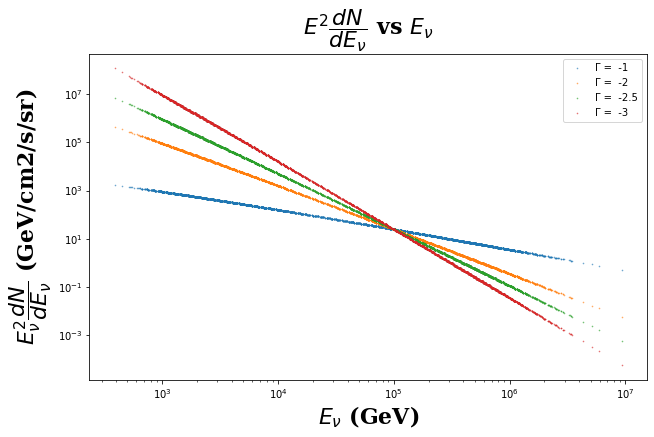

In [120]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.figure(figsize=(10,6))
for i in range(4):
    #plt.scatter(all_tsmax_nu_all_gamma[i], first10000[i])
    plt.scatter( 10 ** (iceng[0:10000]), first10000[i], label = ['\u0393 =  -1', '\u0393 =  -2', '\u0393 =  -2.5', '\u0393 =  -3'][i], s = 0.4, alpha=0.6)

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$E_{\u03BD}$ (GeV)', fontdict=font)
plt.ylabel('$E_{\u03BD}^{2} \dfrac{dN}{dE_{\u03BD}}$ (GeV/cm2/s/sr)', fontdict=font)
plt.legend()
plt.title("$E^{2} \dfrac{dN}{dE_{\u03BD}}$ vs $E_{\u03BD}$", fontdict=font)
plt.savefig('outputs/stacking analysis/E2dNdE_nu-vs-E_nu.jpg')
plt.show()

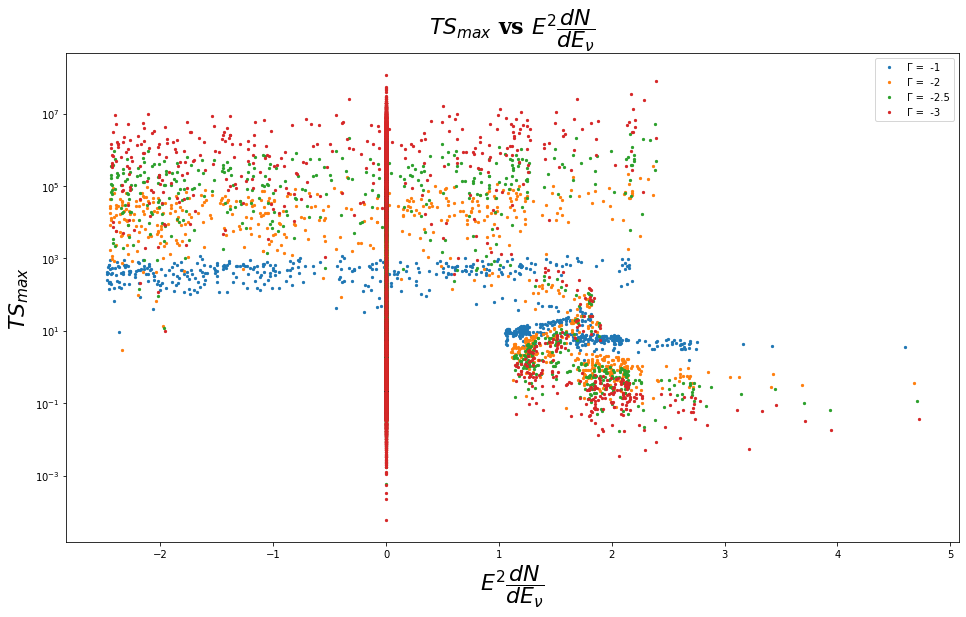

In [126]:
plt.figure(figsize=(16,9))
for i in range(4):
    plt.scatter(all_tsmax_nu_all_gamma[i], first10000[i],  label = ['\u0393 =  -1', '\u0393 =  -2', '\u0393 =  -2.5', '\u0393 =  -3'][i], s = 5)
    
#plt.xscale('log')
plt.yscale('log')
plt.ylabel('$TS_{max}$', fontdict=font)
plt.xlabel('$E^{2} \dfrac{dN}{dE_{\u03BD}}$', fontdict=font)
plt.legend()
plt.title("$TS_{max}$ vs $E^{2} \dfrac{dN}{dE_{\u03BD}}$", fontdict=font)
plt.savefig('outputs/stacking analysis/TSmax-vs-E2dNdE_nu.jpg')
plt.show()